# 

In [2]:
%run ../utils-notebook/load_data.py
%run ../utils-notebook/plot.py
%run ../utils-notebook/imports.py
%run ../utils-notebook/dimensionality_reduction.py
%run ../utils-notebook/clustering.py
%run ../utils-notebook/validate.py

In [3]:
X, y = load_w2v(5000)


c:\Users\acero\Work_Research\DRZoom\src\experiments\17_HDBSCAN
c:\Users\acero\Work_Research\DRZoom\src\experiments\utils-notebook
Number of words in the model: 3000000
shape of vector: (5000, 300)


In [16]:
from sklearn.preprocessing import normalize
X = normalize(X)

In [44]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5,
                            min_samples=7,
                            cluster_selection_method='eom',
                            max_cluster_size=1000,
                            gen_min_span_tree=True)
clusterer.fit(X)
labels = clusterer.labels_
probabilities = clusterer.probabilities_
print(len(set(labels)) - (1 if -1 in labels else 0))  # ノイズを除いたクラスタ数


38


In [40]:
labels = clusterer.labels_


In [73]:
reducer = umap.UMAP(n_neighbors=15,
                    min_dist=0.1,
                    n_components=2,
                    random_state=42)
X_umap = reducer.fit_transform(X)

c:\Users\acero\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



# DBSCANの階層構造の切り出し

# MSTを特定のλで切ったときのクラスタ

<Axes: ylabel='$\\lambda$ value'>

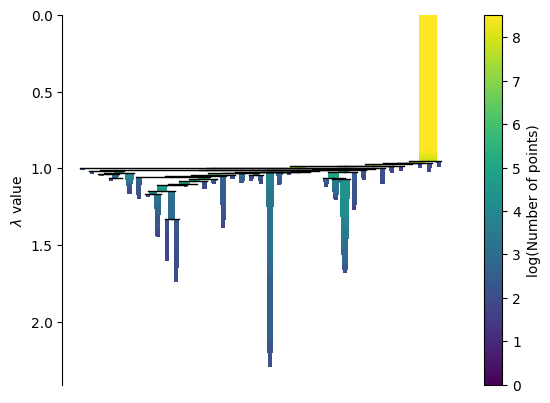

In [45]:
clusterer.condensed_tree_.plot(leaf_separation=0.5, log_size=True, max_rectangles_per_icicle=10)

In [32]:
lam = 1
condensed_tree = clusterer.condensed_tree_.to_pandas()
min_lam = condensed_tree['lambda_val'].min()
max_lam = condensed_tree['lambda_val'].max()
print(f"Min lambda: {min_lam}, Max lambda: {max_lam}")
for lam in np.linspace(min_lam, max_lam-1, 10):
    print(f"Lambda: {lam}")
    labels = clusterer.single_linkage_tree_.get_clusters(lam)
    print(np.unique(labels))



Min lambda: 0.7634536794615071, Max lambda: 2.2939852868517216
Lambda: 0.7634536794615071
[-1  0  1  2  3  4]
Lambda: 0.8224016358381976
[-1  0  1  2  3  4  5]
Lambda: 0.8813495922148882
[-1  0  1  2  3  4  5  6  7  8]
Lambda: 0.9402975485915787
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Lambda: 0.9992455049682691
[-1  0  1  2  3  4  5]
Lambda: 1.0581934613449597
[-1  0]
Lambda: 1.11714141772165
[-1  0]
Lambda: 1.1760893740983407
[-1  0]
Lambda: 1.235037330475031
[-1  0]
Lambda: 1.2939852868517216
[-1  0]


In [ ]:
plot_2d_facets

# クラスタから代表点を選ぶ

## クラスタ寿命と

In [ ]:
# クラスタから、λをもとに代表点を選ぶ関数
def exemplars(cluster_id, raw_tree):
    
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    # print(f"leave num: {len(leaves)}")
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max() if len(raw_tree['lambda_val'][raw_tree['parent'] == leaf]) > 0 else 0
        points = raw_tree['child'][(raw_tree['parent'] == leaf) &
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(int)

In [51]:
clusterer.condensed_tree_._raw_tree

array([(5000,    0, 0.76345368, 1), (5000, 3378, 0.8070868 , 1),
       (5000, 4737, 0.81540527, 1), ..., (5076,   84, 1.44522494, 1),
       (5076,  499, 1.44522494, 1), (5076, 4991, 1.44522494, 1)],
      dtype=[('parent', '<i8'), ('child', '<i8'), ('lambda_val', '<f8'), ('child_size', '<i8')])

In [76]:

for i in clusterer.condensed_tree_._select_clusters():
    print(f"Cluster {i}:")
    selected_exemplars = exemplars(i, clusterer.condensed_tree_._raw_tree)
    print("Selected exemplars indices:", selected_exemplars)

Cluster 5002.0:
Selected exemplars indices: [2460  979  481 3201  575]
Cluster 5004.0:
Selected exemplars indices: [2146 1902 3581 4883 3708]
Cluster 5006.0:
Selected exemplars indices: [3076 1493 3156  636 2404 2216]
Cluster 5008.0:
Selected exemplars indices: [1243  489  243  637  561]
Cluster 5010.0:
Selected exemplars indices: [2868 1809 2818 4380 4594]
Cluster 5012.0:
Selected exemplars indices: [1042  590 1985 4965 1678]
Cluster 5014.0:
Selected exemplars indices: [1388 2749 1384 3177 2260]
Cluster 5015.0:
Selected exemplars indices: [1360 1011  454  921 2041  845]
Cluster 5018.0:
Selected exemplars indices: [ 422  559  786  615 2148]
Cluster 5020.0:
Selected exemplars indices: [ 753 1741 1717  983 1299]
Cluster 5024.0:
Selected exemplars indices: [2934 2885 4372 4711 3223]
Cluster 5027.0:
Selected exemplars indices: [4227 1942  285 2903 1030 1599]
Cluster 5030.0:
Selected exemplars indices: [3159 2031 1704 2946 2952]
Cluster 5031.0:
Selected exemplars indices: [2751  824 1154 25

In [89]:
# 代表点のプロット

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_umap[:, 0],
                        y=X_umap[:, 1],
                        mode='markers',
                        marker=dict(color='lightgrey'),
                        name='Data Points'))
for i in clusterer.condensed_tree_._select_clusters():
    selected_exemplars = exemplars(i, clusterer.condensed_tree_._raw_tree)
    fig.add_trace(go.Scatter(x=X_umap[selected_exemplars, 0],
                            y=X_umap[selected_exemplars, 1],
                            mode='markers',
                            name=f'Cluster {i} Exemplars'))
    
fig.update_layout(width=800, height=600)
fig.update_traces(marker=dict(size=3))
fig.show()


## 所属確率の高い点の選出

In [83]:
probabilities = clusterer.probabilities_
# -1を除くクラスタのラベル
unique_labels = np.unique(labels)
N_TOP = 5
unique_labels = unique_labels[unique_labels != -1]

def get_cluster_lifetimes(c):
    # 1. クラスタに属するインデックスを取得
    cluster_indices = np.where(labels == c)[0]
    
    # 2. 該当するインデックスのメンバシップ確率を取得
    cluster_probabilities = probabilities[cluster_indices]
    
    # 3. 確率に基づいて降順でソートし、上位 N 個のインデックスを取得
    # argsort() は昇順なので、[::-1] で逆転させて降順にする
    sorted_indices_in_cluster = np.argsort(cluster_probabilities)[::-1]
    top_n_indices_in_cluster = sorted_indices_in_cluster[:N_TOP]
    
    # 4. 元のデータセットにおけるインデックスに戻し、単語とスコアを取得
    original_indices = cluster_indices[top_n_indices_in_cluster]
    top_words = [y[i] for i in original_indices]
    top_scores = cluster_probabilities[top_n_indices_in_cluster]
    
    
    return original_indices

for c in unique_labels:
    top_indices = get_cluster_lifetimes(c)
    print(f"Cluster {c} top {N_TOP} exemplars indices: {top_indices}")
      



Cluster 0 top 5 exemplars indices: [3201 2460  979  575  481]
Cluster 1 top 5 exemplars indices: [4883 3708 3581 2146 1902]
Cluster 2 top 5 exemplars indices: [3156 3076 2404 2216 1493]
Cluster 3 top 5 exemplars indices: [1243  637  561  489  243]
Cluster 4 top 5 exemplars indices: [4594 4380 2868 2818 1809]
Cluster 5 top 5 exemplars indices: [4965 1985 1678 1042  590]
Cluster 6 top 5 exemplars indices: [3177 2749 2260 1388 1384]
Cluster 7 top 5 exemplars indices: [2041 1360 1011  921  845]
Cluster 8 top 5 exemplars indices: [2148  786  615  559  422]
Cluster 9 top 5 exemplars indices: [1741 1717 1299  983  753]
Cluster 10 top 5 exemplars indices: [4711 4372 3223 2934 2885]
Cluster 11 top 5 exemplars indices: [4227 2903 1942 1599 1030]
Cluster 12 top 5 exemplars indices: [3159 2952 2946 2031 1704]
Cluster 13 top 5 exemplars indices: [2751 2594 1154  917  824]
Cluster 14 top 5 exemplars indices: [ 752 2968 1062 1155 3109]
Cluster 15 top 5 exemplars indices: [3854 1719 1148 1316 2133]
Cl

In [88]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_umap[:, 0],
                        y=X_umap[:, 1],
                        mode='markers',
                        marker=dict(color='lightgrey'),
                        name='Data Points'))
for i in unique_labels:
    selected_exemplars = get_cluster_lifetimes(i)

    fig.add_trace(go.Scatter(x=X_umap[selected_exemplars, 0],
                            y=X_umap[selected_exemplars, 1],
                            mode='markers',
                            name=f'Cluster {i} Exemplars'))
    
fig.update_layout(width=800, height=600)
fig.update_traces(marker=dict(size=3))
fig.show()

In [95]:
# 代表点だけで次元削減
selected_indices = []
selected_point_labels = []  
for c in unique_labels:
    top_indices = get_cluster_lifetimes(c)
    selected_indices.extend(top_indices)
    selected_point_labels.extend([c] * len(top_indices))
X_selected = X[selected_indices]

print(f"Selected exemplars shape: {X_selected.shape}")
reducer = umap.UMAP(n_neighbors=15,
                    min_dist=0.1,
                    n_components=2,
                    random_state=42)
X_selected_umap = reducer.fit_transform(X_selected)

fig = px.scatter(x=X_selected_umap[:, 0],   
                    y=X_selected_umap[:, 1],
                    color=np.array(selected_point_labels).astype(str),
                    title="UMAP of Selected Exemplars",
                    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'color': 'Cluster Label'})
fig.update_layout(width=800, height=800)
fig.show()

Selected exemplars shape: (190, 300)


c:\Users\acero\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [97]:
X_selected_pca = PCA(n_components=3, random_state=42).fit_transform(X_selected)
fig = px.scatter_3d(x=X_selected_pca[:, 0],   
                    y=X_selected_pca[:, 1],
                    z=X_selected_pca[:, 2],
                    color=np.array(selected_point_labels).astype(str),
                    title="PCA of Selected Exemplars",
                    labels={'x': 'PCA 1', 'y': 'PCA 2', 'color': 'Cluster Label'})
fig.update_layout(width=800, height=800)
fig.show()

# 